# 2. CML processing 
In this notebook cml are processed according to the following steps:
* calculate total loss
* simple quality control
* Wet&Dry Classification
* baseline computation 
* rain-induced attenuation
* rain rate estimate

In [1]:
import sys
import os

# # Add the poligrain and mergeplg src directories to Python's path
sys.path.insert(0, os.path.abspath("./poligrain/src"))
sys.path.insert(0, os.path.abspath("./pycomlink"))


In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pycomlink as pycml
import poligrain as plg


/home/erlend/Documents/GitHub/OpenMRG2/pycomlink/pycomlink/io/examples.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [3]:
# Load CML and radar data
ds_cmls = xr.open_dataset('data/andersson_2022_OpenMRG/openMRG_cml.nc')
ds_rad = xr.open_dataset('data/andersson_2022_OpenMRG/radar/openmrg_rad.nc') 

In [4]:
# Select sublink 0
ds_cmls = ds_cmls.isel(sublink_id = 0)

In [5]:
# calculate total loss
ds_cmls["tl"] = ds_cmls.tsl - ds_cmls.rsl

# Interpolate na
ds_cmls['tl'] = ds_cmls.tl.interpolate_na(dim='time', method='linear', max_gap='5min')

# flag cmls with strong diurnal fluctuations
qc_diurnalcicle = (ds_cmls.tl.rolling(time=60 * 5, center=True).std() > 2).mean(dim="time") > 0.1

# flag cmls with very noisy periods
qc_noisyperiods = (ds_cmls.tl.rolling(time=60, center=True).std() > 0.8).mean(dim="time") > 0.20

ds_cmls.where(qc_diurnalcicle, drop=True);
ds_cmls.where(qc_noisyperiods, drop=True);

In [7]:
da_intersect_weights = plg.spatial.calc_sparse_intersect_weights_for_several_cmls(
    x1_line=ds_cmls.site_0_lon.values,
    y1_line=ds_cmls.site_0_lat.values,
    x2_line=ds_cmls.site_1_lon.values,
    y2_line=ds_cmls.site_1_lat.values,
    cml_id=ds_cmls.cml_id.values,
    x_grid=ds_rad.lon.values,
    y_grid=ds_rad.lat.values,
    grid_point_location='center',
)

da_radar_along_cmls = plg.spatial.get_grid_time_series_at_intersections(
    grid_data=ds_rad.rainfall_amount,
    intersect_weights=da_intersect_weights,
).resample(time = '1min').bfill()*4 # to mm/h

# Set wet periods above threshold
ds_cmls['wet_radar']  = (da_radar_along_cmls > 0.01).rolling(time=5, center=True).max() # the radar is a bit low

In [8]:
roll_std_dev = ds_cmls.tl.rolling(time=60, center=True).std()
threshold = 1.12 * roll_std_dev.quantile(0.8, dim="time")
ds_cmls["wet_cml"] = (roll_std_dev > threshold)

/home/erlend/miniforge3/envs/openmrg/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


In [9]:
# Estimate baseline
ds_cmls["baseline"] = pycml.processing.baseline.baseline_constant(
    trsl=ds_cmls.tl,
    wet=ds_cmls.wet_cml.astype(bool)| ds_cmls.wet_radar.astype(bool), # wet period if radar or CML is wet
    n_average_last_dry=5,
)

ds_cmls["A_obs"] = ds_cmls.tl - ds_cmls.baseline
ds_cmls["A_obs"] = ds_cmls.A_obs.where(ds_cmls.A_obs >= 0, 0)

# Pastorek using parameters that looks good for the German,
# Swedish and Norwegian dataset
ds_cmls["waa"] = pycml.processing.wet_antenna.waa_pastorek_2021_from_A_obs(
    A_obs=ds_cmls.A_obs,
    f_Hz=ds_cmls.frequency * 1e6,
    pol=ds_cmls.polarization.data,
    L_km=ds_cmls.length / 1000,
    A_max=6,
    zeta=0.7,  # 0.55 is default
    d=0.15,
)

# calculate attenuation caused by rain and remove negative attenuation
ds_cmls["A"] = ds_cmls.tl - ds_cmls.baseline - ds_cmls.waa
ds_cmls["A"].data[ds_cmls.A < 0] = 0

# derive rain rate via the k-R relation
ds_cmls["R"] = pycml.processing.k_R_relation.calc_R_from_A(
    A=ds_cmls.A,
    L_km=ds_cmls.length.astype(float) / 1000,  # convert to km
    f_GHz=ds_cmls.frequency / 1000,  # convert to GHz
    pol=ds_cmls.polarization,
)

In [10]:
ds_cml_res = (
    ds_cmls[["R"]]
    .resample(time="15min", label='right', closed='right')
    .sum(skipna=True)
    / 60
)

(array([0.00026499, 0.0018549 , 0.00105994, 0.00211988, 0.00211988,
        0.00635965, 0.00635965, 0.00768458, 0.00768458, 0.00635965,
        0.00556469, 0.00688962, 0.00662463, 0.00503472, 0.00397478,
        0.00423977, 0.00238487, 0.0018549 , 0.0018549 , 0.00211988,
        0.00264985, 0.00132493, 0.00026499, 0.00079496, 0.00026499,
        0.00158991, 0.00105994, 0.00026499, 0.        ]),
 array([180.        , 191.03448276, 202.06896552, 213.10344828,
        224.13793103, 235.17241379, 246.20689655, 257.24137931,
        268.27586207, 279.31034483, 290.34482759, 301.37931034,
        312.4137931 , 323.44827586, 334.48275862, 345.51724138,
        356.55172414, 367.5862069 , 378.62068966, 389.65517241,
        400.68965517, 411.72413793, 422.75862069, 433.79310345,
        444.82758621, 455.86206897, 466.89655172, 477.93103448,
        488.96551724, 500.        ]),
 <BarContainer object of 29 artists>)

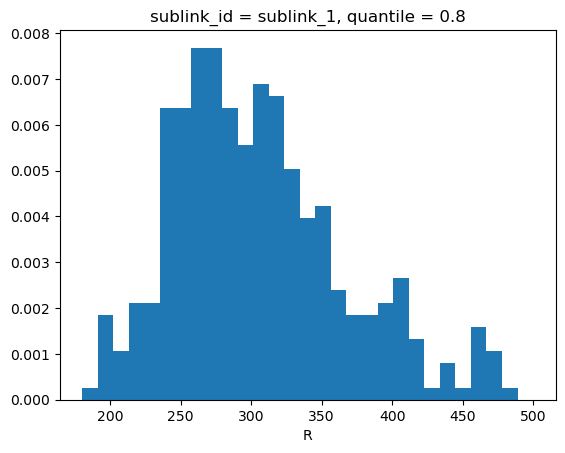

In [11]:
(ds_cml_res.R.sum(dim='time')).plot.hist(bins=np.linspace(180,500,30), density=True)


In [12]:
# saving output
ds_cml_res.to_netcdf('data/processed_cml_OpenMRG.nc')